In [10]:
import pandas as pd
import os

# Folder where your route files are stored
folder_path = r"E:\BS_20_30_mod_new\BS_20_30"

# Load all route data into a dictionary
route_data = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # Ensure only CSV files are read
        route_id = filename.split(".")[0].split("SB")[0]  # Extract route number
        df = pd.read_csv(os.path.join(folder_path, filename))
        route_data[route_id] = df

# Print the first few stops of Route 1 as a test
print(route_data["21"].head())

    Latitude  Longitude                    Place
0  13.048510  80.197906            Avichi School
1  13.048189  80.203520         Sooriya Hospital
2  13.050445  80.206868         Vadapalani Depot
3  13.049987  80.212191        Vadapalani Signal
4  13.040131  80.212626  Ashok Nagar Canara Bank


In [11]:
import folium

# Create a base map centered at SSN College
m = folium.Map(location=[12.9716, 80.2332], zoom_start=12)

# Plot each route with a different color
route_colors = ["red", "blue", "green", "purple", "orange", "darkblue", "darkred", "cadetblue"]

for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    
    # Add route path as a polyline
    folium.PolyLine(df[["Latitude","Longitude"]].values, color=color, weight=2.5, opacity=1).add_to(m)

    # Add stop markers
    for _, row in df.iterrows():
        folium.Marker(location=[row["Latitude"], row["Longitude"]], popup=row["Place"]).add_to(m)

# Save and display the original route map
m.save("original_routes_map.html")

In [12]:
for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    
    # Diagnose the data
    print(f"Route ID: {route_id}")
    print(df[["Latitude","Longitude"]].head())  # Print first few rows
    
    # Add route path as a polyline
    folium.PolyLine(df[["Latitude","Longitude"]].values, color=color, weight=2.5, opacity=1).add_to(m)

Route ID: 20
    Latitude  Longitude
0  13.058033  80.265069
1  13.054653  80.264430
2  13.052317  80.263756
3  13.047315  80.266331
4  13.041666  80.268214
Route ID: 21
    Latitude  Longitude
0  13.048510  80.197906
1  13.048189  80.203520
2  13.050445  80.206868
3  13.049987  80.212191
4  13.040131  80.212626
Route ID: 22
    Latitude  Longitude
0  13.040324  80.199761
1  13.041832  80.202781
2  13.036857  80.205442
3  13.035669  80.208311
4  13.037007  80.212102
Route ID: 23
    Latitude  Longitude
0  13.024625  80.216537
1  13.025601  80.219578
2  13.037323  80.215570
3  13.036848  80.218604
4  13.039169  80.220949
Route ID: 24
    Latitude  Longitude
0  13.052297  80.219648
1  13.053896  80.227458
2  13.052030  80.235775
3  13.050767  80.233669
4  13.035218  80.230909
Route ID: 25
    Latitude  Longitude
0  13.064285  80.278322
1  13.059367  80.273439
2  13.058880  80.274023
3  13.058435  80.276799
4  13.039329  80.279089
Route ID: 26A
    Latitude  Longitude
0  12.964927  80.196

In [13]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd

# 📌 Define the location of SSN College
ssn_lat, ssn_lon = 12.8177, 80.0344
place_name = "Chennai, India"

# 🔹 Step 1: Load Road Network with Better Connectivity
G = ox.graph_from_place(place_name, network_type="all")

# Ensure Graph is Weakly Connected (fixes disconnected roads)
largest_component = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_component).copy()

# 🔹 Step 2: Find the nearest road node to SSN College
ssn_node = ox.distance.nearest_nodes(G, ssn_lon, ssn_lat)

# 🔹 Step 4: Function to Map Stops to the Nearest Road Nodes
def get_nearest_nodes(df):
    """ Maps each bus stop to the closest road node in the OSM network """
    nodes = []
    for lat, lon in df[["Latitude", "Longitude"]].values:
        try:
            nearest = ox.distance.nearest_nodes(G, lon, lat)
            nodes.append(nearest)
        except Exception as e:
            print(f"⚠️ No road node found for stop ({lat}, {lon}): {e}")
            nodes.append(None)  # Mark as None if no node found
    return nodes

# Create Folium Map Centered at SSN College
m = folium.Map(location=[ssn_lat, ssn_lon], zoom_start=12)

# Route Colors
route_colors = ["red", "blue", "green", "purple", "orange", "darkblue", "darkred", "cadetblue"]

# 🔹 Step 5: Process Each Route
for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    
    # Get nearest road nodes for stops
    stop_nodes = get_nearest_nodes(df)

    # Remove None values
    stop_nodes = [node for node in stop_nodes if node is not None]

    # Ensure all routes end at SSN College
    if ssn_node not in stop_nodes:
        stop_nodes.append(ssn_node)

    # Check if there are at least two valid stops
    if len(stop_nodes) < 2:
        print(f"⚠️ Skipping {route_id}: Not enough connected stops.")
        continue

    road_path = []  # Store the full route path along roads
    
    # 🔹 Step 6: Find the Shortest Road Path to SSN College
    for j in range(len(stop_nodes) - 1):
        try:
            path = nx.shortest_path(G, stop_nodes[j], stop_nodes[j + 1], weight="length")
            road_path.extend(path)  # Append path to the full route
        except nx.NetworkXNoPath:
            print(f"⚠️ No road path found between {stop_nodes[j]} and {stop_nodes[j + 1]}. Retrying with alternatives...")
            
            # Try alternative routing by going through a nearby major node
            alternative_nodes = list(G.nodes)[:5]  # Sample a few major nodes
            for alt in alternative_nodes:
                try:
                    path = nx.shortest_path(G, stop_nodes[j], alt, weight="length") + \
                           nx.shortest_path(G, alt, stop_nodes[j + 1], weight="length")
                    road_path.extend(path)
                    break
                except nx.NetworkXNoPath:
                    continue

    # Convert road path nodes to (lat, lon) for visualization
    road_coordinates = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in road_path]

    # Add route as a Polyline
    folium.PolyLine(road_coordinates, color=color, weight=3, opacity=0.8, tooltip=f"Bus {route_id}").add_to(m)

    # Add stop markers with bus icons
    for _, row in df.iterrows():
        folium.Marker(location=[row["Latitude"], row["Longitude"]], popup=row["Place"], 
                      icon=folium.Icon(color="blue", icon="bus", prefix="fa")).add_to(m)

# Add SSN College Marker
folium.Marker(location=[ssn_lat, ssn_lon], popup="SSN College of Engineering", 
              icon=folium.Icon(color="green", icon="graduation-cap", prefix="fa")).add_to(m)

# Save and display the map
m.save("ssn_converging_routes_fixed.html")
print("✅ Map saved as ssn_converging_routes_fixed.html")


⚠️ No road path found between 303682723 and 7043109276. Retrying with alternatives...
✅ Map saved as ssn_converging_routes_fixed.html


In [17]:
place_name = "Chennai, India"

# 🔹 Step 1: Download Road Network (Using 'all' instead of 'drive' to avoid missing paths)
G = ox.graph_from_place(place_name, network_type="all")
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
largest_component = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_component).copy()

In [24]:
ssn_lat, ssn_lon = 12.8177, 80.0344
ssn_node = ox.distance.nearest_nodes(G, ssn_lon, ssn_lat)
# 🔹 Step 4: Function to Map Stops to the Nearest Road Nodes
def get_nearest_nodes(df):
    """ Maps each bus stop to the closest road node in the OSM network """
    nodes = []
    for lat, lon in df[["Latitude", "Longitude"]].values:
        try:
            nearest = ox.distance.nearest_nodes(G, lon, lat)
            nodes.append(nearest)
        except Exception as e:
            print(f"⚠️ No road node found for stop ({lat}, {lon}): {e}")
            nodes.append(None)  # Mark as None if no node found
    return nodes

# Create Folium Map Centered at SSN College
m = folium.Map(location=[ssn_lat, ssn_lon], zoom_start=12)

# Route Colors
route_colors = ["red", "blue", "green", "purple", "orange", "darkblue", "darkred", "cadetblue"]

# 🔹 Step 5: Process Each Route
for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    
    # Get nearest road nodes for stops
    stop_nodes = get_nearest_nodes(df)

    # Remove None values
    stop_nodes = [node for node in stop_nodes if node is not None]

    # Ensure all routes end at SSN College
    if ssn_node not in stop_nodes:
        stop_nodes.append(ssn_node)

    # Check if there are at least two valid stops
    if len(stop_nodes) < 2:
        print(f"⚠️ Skipping {route_id}: Not enough connected stops.")
        continue

    road_path = []  # Store the full route path along roads
    
    # 🔹 Step 6: Find the Shortest Road Path to SSN College
    for j in range(len(stop_nodes) - 1):
        try:
            path = nx.shortest_path(G, stop_nodes[j], stop_nodes[j + 1], weight="length")
            road_path.extend(path)  # Append path to the full route
        except nx.NetworkXNoPath:
            print(f"⚠️ No road path found between {stop_nodes[j]} and {stop_nodes[j + 1]}. Skipping segment.")

    # Convert road path nodes to (lat, lon) for visualization
    road_coordinates = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in road_path]

    # Add route as a Polyline
    folium.PolyLine(road_coordinates, color=color, weight=3, opacity=0.8, tooltip=f"Bus {route_id}").add_to(m)

    # Add stop markers with bus icons
    for _, row in df.iterrows():
        folium.Marker(location=[row["Latitude"], row["Longitude"]], popup=row["Place"], 
                      icon=folium.Icon(color="blue", icon="bus", prefix="fa")).add_to(m)

# Add SSN College Marker
folium.Marker(location=[ssn_lat, ssn_lon], popup="SSN College of Engineering", 
              icon=folium.Icon(color="green", icon="graduation-cap", prefix="fa")).add_to(m)

# Save and display the map
m.save("ssn_converging_routes.html")
print("✅ Map saved as ssn_converging_routes.html")

✅ Map saved as ssn_converging_routes.html


In [29]:
ssn_node = ox.distance.nearest_nodes(G, ssn_lon, ssn_lat)

# 🔹 Step 4: Function to Map Bus Stops to Nearest Road Nodes
def get_nearest_nodes(df):
    """ Map bus stops to the closest road node in the OSM network """
    nodes = []
    for lat, lon in df[["Latitude", "Longitude"]].values:
        try:
            nearest = ox.distance.nearest_nodes(G, lon, lat)
            nodes.append(nearest)
        except Exception as e:
            print(f"⚠️ No road node found for stop ({lat}, {lon}): {e}")
            nodes.append(None)  # Mark as None if no node found
    return nodes

# Create Folium Map Centered at SSN College
m = folium.Map(location=[ssn_lat, ssn_lon], zoom_start=12)

# Route Colors
route_colors = ["red", "blue", "green", "purple", "orange", "darkblue", "darkred", "cadetblue"]

# 🔹 Step 5: Process Each Route
for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    
    # Get nearest road nodes for stops
    stop_nodes = get_nearest_nodes(df)

    # Remove None values
    stop_nodes = [node for node in stop_nodes if node is not None]

    # Ensure the route reaches SSN College
    if ssn_node not in stop_nodes:
        stop_nodes.append(ssn_node)

    # Check if there are at least two valid stops
    if len(stop_nodes) < 2:
        print(f"⚠️ Skipping {route_id}: Not enough connected stops.")
        continue

    road_path = []  # Store the full route path along roads
    
    # 🔹 Step 6: Find the Roadway Route
    for j in range(len(stop_nodes) - 1):
        try:
            path = nx.shortest_path(G, stop_nodes[j], stop_nodes[j + 1], weight="length")
            road_path.extend(path)
        except nx.NetworkXNoPath:
            print(f"⚠️ No road path found between {stop_nodes[j]} and {stop_nodes[j + 1]}. Retrying with alternatives...")

            # Alternative routing via nearby main roads
            alternative_nodes = list(G.nodes)[:5]
            for alt in alternative_nodes:
                try:
                    path = nx.shortest_path(G, stop_nodes[j], alt, weight="length") + \
                           nx.shortest_path(G, alt, stop_nodes[j + 1], weight="length")
                    road_path.extend(path)
                    break
                except nx.NetworkXNoPath:
                    continue

    # Convert road path nodes to (lat, lon) for visualization
    road_coordinates = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in road_path]

    # Add route as a Polyline
    folium.PolyLine(road_coordinates, color=color, weight=3, opacity=0.8, tooltip=f"Bus {route_id}").add_to(m)

    # Add stop markers with bus icons
    for _, row in df.iterrows():
        folium.Marker(location=[row["Latitude"], row["Longitude"]], popup=row["Place"], 
                      icon=folium.Icon(color="blue", icon="bus", prefix="fa")).add_to(m)

# Add SSN College Marker
folium.Marker(location=[ssn_lat, ssn_lon], popup="SSN College of Engineering", 
              icon=folium.Icon(color="green", icon="graduation-cap", prefix="fa")).add_to(m)

# Save and display the map
m.save("optimized_bus_routes.html")
print("✅ Map saved as optimized_bus_routes.html")

⚠️ No road path found between 303682723 and 7043109276. Retrying with alternatives...
✅ Map saved as optimized_bus_routes.html


In [35]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm

# Constants
SSN_LAT = 12.7507  # SSN College latitude
SSN_LON = 80.2014  # SSN College longitude
BUFFER_DIST = 40000 # 10km buffer around SSN for network extraction

print("🔄 Loading road network around SSN College...")
# Get a larger road network to ensure connectivity
# Set 'simplify=True' to simplify the graph topology and 'network_type='drive'' for road network
G = ox.graph_from_point((SSN_LAT, SSN_LON), dist=BUFFER_DIST, network_type='drive', simplify=True)

# Convert to undirected graph for certain operations
G_undirected = G.to_undirected()

print(f"✅ Network loaded: {len(G.nodes)} nodes, {len(G.edges)} edges")

# Find the node closest to SSN College
ssn_node = ox.distance.nearest_nodes(G, SSN_LON, SSN_LAT)
print(f"✅ SSN College mapped to node: {ssn_node}")

# Sample bus route data (replace with your actual data)
# Replace with your data if available

# Create a map centered at SSN College
m = folium.Map(location=[SSN_LAT, SSN_LON], zoom_start=12)

# Add SSN marker
folium.Marker(
    location=[SSN_LAT, SSN_LON],
    popup="SSN College of Engineering",
    icon=folium.Icon(color="green", icon="graduation-cap", prefix="fa")
).add_to(m)

# Route colors for visualization
route_colors = ["red", "blue", "green", "purple", "orange", "darkblue", "darkred", "cadetblue"]

def find_route_with_fallback(G, start_node, end_node):
    """
    Try multiple routing strategies to find a path between nodes
    """
    # Strategy 1: Direct shortest path
    try:
        return nx.shortest_path(G, start_node, end_node, weight="length")
    except nx.NetworkXNoPath:
        pass
    
    # Strategy 2: Via some random high-degree nodes (likely intersections)
    try:
        # Find nodes with high degree (major intersections)
        degrees = dict(G.degree())
        sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        waypoints = [node for node, degree in sorted_nodes[:20] if node != start_node and node != end_node]
        
        for mid_node in waypoints:
            try:
                path1 = nx.shortest_path(G, start_node, mid_node, weight="length")
                path2 = nx.shortest_path(G, mid_node, end_node, weight="length")
                return path1 + path2[1:]  # Combine paths, avoiding duplicate mid_node
            except nx.NetworkXNoPath:
                continue
    except Exception as e:
        print(f"Strategy 2 error: {e}")
    
    # Strategy 3: Try via multiple waypoints in sequence
    try:
        # Sample some nodes as potential waypoints
        sample_size = min(10, len(G.nodes))
        sample_nodes = list(G.nodes())[:sample_size]
        
        # Try routing via pairs of waypoints
        for mid1 in sample_nodes:
            for mid2 in sample_nodes:
                if mid1 != mid2 and mid1 != start_node and mid2 != end_node:
                    try:
                        path1 = nx.shortest_path(G, start_node, mid1, weight="length")
                        path2 = nx.shortest_path(G, mid1, mid2, weight="length")
                        path3 = nx.shortest_path(G, mid2, end_node, weight="length")
                        return path1 + path2[1:] + path3[1:]
                    except nx.NetworkXNoPath:
                        continue
    except Exception as e:
        print(f"Strategy 3 error: {e}")
    
    # Strategy 4: Check if nodes are in the same connected component in undirected version
    try:
        # Use weakly connected components for directed graph
        # This is equivalent to connected components in the undirected version
        G_wcc = nx.weakly_connected_components(G)
        start_component = None
        
        # Find which component contains the start node
        for component in G_wcc:
            if start_node in component:
                start_component = component
                break
        
        if start_component and end_node in start_component:
            # They're in the same component, but shortest_path failed
            # Try with higher weight tolerance or different weight
            try:
                # Try with straight-line distance as heuristic
                return nx.astar_path(G, start_node, end_node, 
                                    heuristic=lambda u, v: ((G.nodes[u]['y'] - G.nodes[v]['y'])**2 + 
                                                           (G.nodes[u]['x'] - G.nodes[v]['x'])**2)**0.5)
            except Exception:
                pass
        
        if start_component:
            # Find closest node in the component to the destination
            closest_node = min(
                start_component,
                key=lambda n: ((G.nodes[n]['y'] - G.nodes[end_node]['y'])**2 + 
                              (G.nodes[n]['x'] - G.nodes[end_node]['x'])**2)
            )
            
            # Route to the closest node instead
            try:
                return nx.shortest_path(G, start_node, closest_node, weight="length")
            except Exception:
                return [start_node]
    except Exception as e:
        print(f"Strategy 4 error: {e}")
    
    # Fallback: Just return the start node if all else fails
    return [start_node]

def clean_coordinates(lat, lon):
    """Validates and cleans coordinate data"""
    try:
        lat, lon = float(lat), float(lon)
        # Check if coordinates are in reasonable range
        if 8 <= lat <= 15 and 77 <= lon <= 83:  # Rough bounds for Tamil Nadu
            return lat, lon
        else:
            return None, None
    except (ValueError, TypeError):
        return None, None

# Process each route
for i, (route_id, df) in enumerate(route_data.items()):
    color = route_colors[i % len(route_colors)]
    print(f"🔄 Processing route {route_id}...")
    
    # Clean and validate coordinates
    valid_stops = []
    for _, row in df.iterrows():
        lat, lon = clean_coordinates(row["Latitude"], row["Longitude"])
        if lat is not None and lon is not None:
            nearest_node = ox.distance.nearest_nodes(G, lon, lat)
            valid_stops.append({
                "place": row["Place"],
                "lat": lat,
                "lon": lon,
                "node": nearest_node
            })
    
    # Ensure route includes SSN College
    if not any(stop["node"] == ssn_node for stop in valid_stops):
        valid_stops.append({
            "place": "SSN College",
            "lat": SSN_LAT,
            "lon": SSN_LON,
            "node": ssn_node
        })
    
    # Skip routes with insufficient stops
    if len(valid_stops) < 2:
        print(f"⚠️ Route {route_id} has insufficient valid stops. Skipping.")
        continue
    
    # Create full path through all stops
    full_path = []
    route_segments = []
    
    # Reorder stops to ensure SSN is the final destination
    ssn_index = next((i for i, stop in enumerate(valid_stops) if stop["node"] == ssn_node), None)
    if ssn_index is not None and ssn_index < len(valid_stops) - 1:
        # Move SSN to the end
        ssn_stop = valid_stops.pop(ssn_index)
        valid_stops.append(ssn_stop)
    
    # Create route segments between consecutive stops
    for j in range(len(valid_stops) - 1):
        start = valid_stops[j]
        end = valid_stops[j + 1]
        
        print(f"  Finding path from {start['place']} to {end['place']}...")
        segment_path = find_route_with_fallback(G, start["node"], end["node"])
        
        if segment_path:
            route_segments.append({
                "start": start["place"],
                "end": end["place"],
                "path": segment_path
            })
            
            # Add to full path, avoiding duplicates
            if not full_path:
                full_path.extend(segment_path)
            else:
                full_path.extend(segment_path[1:])
    
    # Convert node IDs to geographic coordinates
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in full_path]
    
    # Add route to map
    route_name = f"Bus {route_id}: {valid_stops[0]['place']} to {valid_stops[-1]['place']}"
    folium.PolyLine(
        coords,
        color=color, 
        weight=4, 
        opacity=0.8,
        tooltip=route_name
    ).add_to(m)
    
    # Add stop markers
    for stop in valid_stops:
        folium.Marker(
            location=[stop["lat"], stop["lon"]],
            popup=f"{stop['place']} ({route_id})",
            icon=folium.Icon(color=color, icon="bus", prefix="fa")
        ).add_to(m)
    
    print(f"✅ Route {route_id} added with {len(coords)} points")

# Add layer control and other map features
folium.LayerControl().add_to(m)

# Add title
title_html = """
<div style="position: fixed; 
            top: 10px; left: 50px; width: 300px; height: 30px; 
            background-color: white; border:2px solid grey;
            z-index:9999; font-size:16px; font-weight: bold;
            padding: 5px; border-radius: 5px;">
            Bus Routes to SSN College
</div>
"""
m.get_root().html.add_child(folium.Element(title_html))

# Save map to HTML file
output_file = "ssn_bus_routes.html"
m.save(output_file)
print(f"✅ Map saved as {output_file}")

# Print route summary
print("\n🚌 Route Summary:")
for i, route_id in enumerate(route_data.keys()):
    stops = ", ".join([row["Place"] for _, row in route_data[route_id].iterrows()])
    print(f"{i+1}. Route {route_id}: {stops} → SSN College")

🔄 Loading road network around SSN College...
✅ Network loaded: 147285 nodes, 364807 edges
✅ SSN College mapped to node: 11925732126
🔄 Processing route 20...
  Finding path from Royapettah Clock Tower to Royapettah Hospital...
  Finding path from Royapettah Hospital to Royapettah Police Station...
  Finding path from Royapettah Police Station to Ajantha...
  Finding path from Ajantha to Valluvar Statue...
  Finding path from Valluvar Statue to Luz Corner...
  Finding path from Luz Corner to Srinivasapuram(BATA)...
  Finding path from Srinivasapuram(BATA) to SSN...
✅ Route 20 added with 342 points
🔄 Processing route 21...
  Finding path from Avichi School to Sooriya Hospital...
  Finding path from Sooriya Hospital to Vadapalani Depot...
  Finding path from Vadapalani Depot to Vadapalani Signal...
  Finding path from Vadapalani Signal to Ashok Nagar Canara Bank...
  Finding path from Ashok Nagar Canara Bank to Ashok Nagar...
  Finding path from Ashok Nagar to Srinivasa theatre...
  Findin

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS  # Better for density-based spatial clustering
import numpy as np
import folium
from geographiclib.geodesic import Geodesic

# Assuming SSN coordinates (replace with actual values)
SSN_COORDS = (12.9716, 80.2332)  # Example: Chennai coordinates

def calculate_route_features(route_df):
    """Calculate directional and spatial features for a route"""
    features = {
        'num_stops': len(route_df),
        'total_distance': 0,
        'ssn_direction_deviation': [],
        'curvature': []
    }
    
    prev_stop = None
    for _, stop in route_df.iterrows():
        if prev_stop is not None:
            # Calculate segment direction relative to SSN
            seg_vector = np.array([stop['Longitude'] - prev_stop['Longitude'],
                                  stop['Latitude'] - prev_stop['Latitude']])
            ssn_vector = np.array([SSN_COORDS[1] - prev_stop['Longitude'],
                                  SSN_COORDS[0] - prev_stop['Latitude']])
            
            # Calculate angle between segment and SSN direction
            cos_theta = np.dot(seg_vector, ssn_vector) / (np.linalg.norm(seg_vector) * np.linalg.norm(ssn_vector))
            features['ssn_direction_deviation'].append(np.arccos(cos_theta))
            
            # Calculate curvature
            geo_calc = Geodesic.WGS84.Inverse(prev_stop['Latitude'], prev_stop['Longitude'],
                                            stop['Latitude'], stop['Longitude'])
            features['curvature'].append(geo_calc['azi2'] - geo_calc['azi1'])
            
            # Accumulate distance
            features['total_distance'] += geo_calc['s12'] / 1000  # Convert to km
            
        prev_stop = stop
    
    # Aggregate features
    features['avg_direction_deviation'] = np.mean(features['ssn_direction_deviation'])
    features['direction_consistency'] = np.std(features['ssn_direction_deviation'])
    features['avg_curvature'] = np.mean(features['curvature'])
    
    return features

# Process all routes
route_features = []
for route_id, stops in route_data.items():
    features = calculate_route_features(stops)
    route_features.append([
        features['avg_direction_deviation'],
        features['direction_consistency'],
        features['total_distance'],
        features['num_stops'],
        features['avg_curvature']
    ])

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(route_features)

# Cluster using density-based method (handles non-spherical clusters)
cluster_model = OPTICS(min_samples=2, metric='euclidean')
clusters = cluster_model.fit_predict(scaled_features)

# Create enhanced visualization
def create_cluster_map(route_data, clusters):
    cluster_map = folium.Map(location=SSN_COORDS, zoom_start=12)
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080']
    
    # Add SSN reference marker
    folium.Marker(
        location=SSN_COORDS,
        icon=folium.Icon(color='black', icon='star'),
        popup="SSN Reference Point"
    ).add_to(cluster_map)
    
    # Plot each route with cluster color
    for (route_id, stops), cluster in zip(route_data.items(), clusters):
        color = colors[cluster % len(colors)]
        folium.PolyLine(
            locations=stops[['Latitude', 'Longitude']].values.tolist(),
            color=color,
            weight=3,
            opacity=0.7,
            popup=f"Route {route_id} (Cluster {cluster})"
        ).add_to(cluster_map)
    
    return cluster_map

# Generate and save map
enhanced_map = create_cluster_map(route_data, clusters)
enhanced_map.save("enhanced_route_clusters.html")


C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


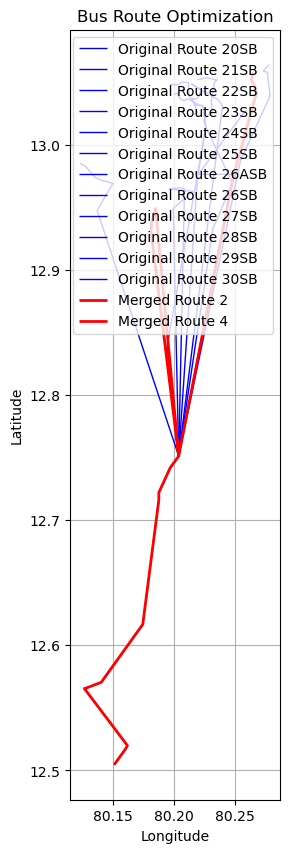

In [4]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from sklearn.cluster import KMeans

# Constants
MAX_CAPACITY = 50  # Maximum number of students per bus

# Load bus route data from multiple CSV files in a folder
def load_bus_routes_from_folder(folder_path):
    all_routes = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            route_id = filename[:-4]  # Remove ".csv" extension
            file_path = os.path.join(folder_path, filename)
            try:
                all_routes[route_id] = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return all_routes

# Calculate distance between two geographical points using Haversine formula
def haversine(coord1, coord2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Clustering routes based on student strengths and locations
def cluster_routes(routes_data, strengths):
    # Prepare data for clustering
    coordinates = []
    for route in routes_data.values():
        avg_latitude = route['Latitude'].mean()
        avg_longitude = route['Longitude'].mean()
        coordinates.append((avg_latitude, avg_longitude))
    
    # Convert strengths to a numpy array for clustering
    strengths_array = np.array(strengths).reshape(-1, 1)

    # Combine coordinates and strengths for clustering
    combined_data = np.hstack((coordinates, strengths_array))

    # Perform KMeans clustering (you can adjust n_clusters as needed)
    kmeans = KMeans(n_clusters=min(5, len(routes_data)), random_state=42)
    labels = kmeans.fit_predict(combined_data)

    return labels

# Merging routes based on clustering results and capacity constraints
def merge_routes(routes_data, labels):
    merged_routes = {}
    
    for label in set(labels):
        cluster_routes_indices = [i for i, x in enumerate(labels) if x == label]
        total_strength = sum([strengths[i] for i in cluster_routes_indices])
        
        if total_strength > MAX_CAPACITY:
            continue  # Skip if total strength exceeds capacity
        
        merged_route_stops = []
        
        for index in cluster_routes_indices:
            merged_route_stops.extend(routes_data[list(routes_data.keys())[index]].to_dict('records'))
        
        merged_routes[label] = pd.DataFrame(merged_route_stops)

    return merged_routes

# Visualization of original and optimized routes using Geopandas and Matplotlib
def visualize_routes(original_routes, optimized_routes):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot original routes in blue
    for route_id, route_data in original_routes.items():
        points = [Point(row['Longitude'], row['Latitude']) for _, row in route_data.iterrows()]
        line = LineString(points)
        gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326").plot(ax=ax, color='blue', linewidth=1, label=f'Original Route {route_id}')

    # Plot optimized routes in red
    for label, optimized_route in optimized_routes.items():
        points = [Point(row['Longitude'], row['Latitude']) for _, row in optimized_route.iterrows()]
        line = LineString(points)
        gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326").plot(ax=ax, color='red', linewidth=2, label=f'Merged Route {label}')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Bus Route Optimization')
    ax.legend()
    plt.grid()
    
    plt.show()

# Main execution flow
if __name__ == "__main__":
    
    folder_path = "E:\\BS_20_30_mod_new\\BS_20_30"  # Path to your folder containing CSV files
    
    # Load all bus routes from the folder
    all_routes_data = load_bus_routes_from_folder(folder_path)

    # Check if any routes were loaded
    if not all_routes_data:
        print("No routes loaded. Check the folder and file paths.")
        exit()

    # Example: Generate random student strengths for each route (replace with actual logic)
    strengths = [random.randint(10, 50) for _ in range(len(all_routes_data))]

    # Cluster routes based on strengths and locations
    labels = cluster_routes(all_routes_data, strengths)

    # Merge routes based on clustering results and capacity constraints
    optimized_routes = merge_routes(all_routes_data, labels)

    # Visualize original vs optimized routes
    visualize_routes(all_routes_data, optimized_routes)

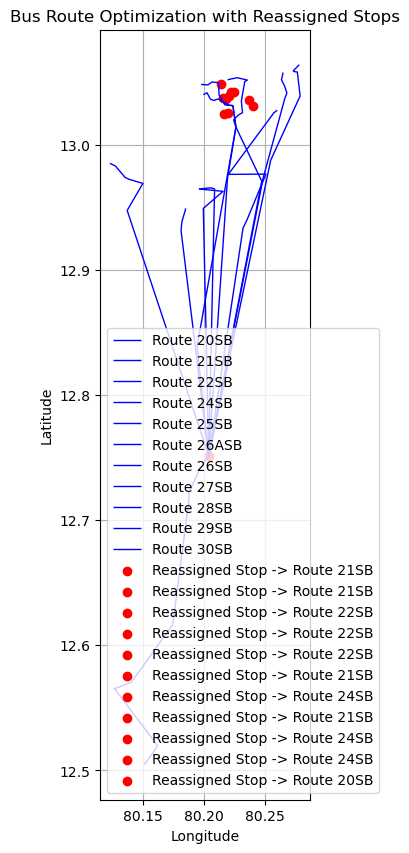

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt

# Constants
MAX_CAPACITY = 50  # Maximum number of students per bus

# Load bus route data from multiple CSV files in a folder
def load_bus_routes(folder_path):
    all_routes = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            route_id = filename[:-4]  # Remove ".csv" extension
            file_path = os.path.join(folder_path, filename)
            try:
                all_routes[route_id] = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return all_routes

# Calculate distance between two geographical points using Haversine formula
def haversine(coord1, coord2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Assign removed route stops to active routes based on proximity and capacity
def reassign_stops(removed_route, active_routes, strengths):
    reassigned_stops = []
    
    for _, stop in removed_route.iterrows():
        min_distance = float('inf')
        assigned_route = None
        
        for route_id, route_data in active_routes.items():
            if strengths[route_id] >= MAX_CAPACITY:  # Skip if the route is full
                continue
            
            # Find the closest stop in the current active route
            for _, active_stop in route_data.iterrows():
                distance = haversine((stop['Latitude'], stop['Longitude']),
                                     (active_stop['Latitude'], active_stop['Longitude']))
                if distance < min_distance:
                    min_distance = distance
                    assigned_route = route_id
        
        if assigned_route:
            reassigned_stops.append((stop['Place'], stop['Latitude'], stop['Longitude'], assigned_route))
            strengths[assigned_route] += 1  # Update the strength of the assigned route
    
    return reassigned_stops

# Visualization of original and optimized routes using Geopandas and Matplotlib
def visualize_routes(original_routes, reassigned_stops):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot original routes in blue
    for route_id, route_data in original_routes.items():
        points = [Point(row['Longitude'], row['Latitude']) for _, row in route_data.iterrows()]
        line = LineString(points)
        gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326").plot(ax=ax, color='blue', linewidth=1, label=f'Route {route_id}')

    # Plot reassigned stops in red
    for stop in reassigned_stops:
        point = Point(stop[2], stop[1])  # Longitude, Latitude
        gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326").plot(ax=ax, color='red', marker='o', label=f'Reassigned Stop -> Route {stop[3]}')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Bus Route Optimization with Reassigned Stops')
    ax.legend()
    plt.grid()
    
    plt.show()

# Main execution flow
if __name__ == "__main__":
    
    folder_path = "E:\\BS_20_30_mod_new\\BS_20_30"  # Path to your folder containing CSV files
    
    # Load all bus routes from the folder
    all_routes_data = load_bus_routes(folder_path)

    # Check if any routes were loaded
    if not all_routes_data:
        print("No routes loaded. Check the folder and file paths.")
        exit()

    # Example: Select a specific route to remove (e.g., "21")
    removed_route_id = "23SB"
    
    if removed_route_id not in all_routes_data:
        print(f"Route {removed_route_id} not found in loaded data.")
        exit()

    removed_route_data = all_routes_data.pop(removed_route_id)  # Remove the selected route

    # Example student strengths for each remaining active route (replace with actual logic)
    strengths = {route_id: random.randint(10, MAX_CAPACITY) for route_id in all_routes_data.keys()}

    # Reassign stops from the removed route to active routes
    reassigned_stops = reassign_stops(removed_route_data, all_routes_data, strengths)

    # Visualize original vs optimized routes with reassigned stops
    visualize_routes(all_routes_data, reassigned_stops)

In [7]:
import pandas as pd
import os
from geopy.distance import geodesic  # For Haversine distance calculation

# Load bus route data from multiple CSV files in a folder
def load_bus_routes(folder_path):
    all_routes = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            route_id = filename[:-4]  # Remove ".csv" extension
            file_path = os.path.join(folder_path, filename)
            try:
                all_routes[route_id] = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return all_routes

# Check if a stop is covered by any stop in another route within a given radius
def is_stop_covered(stop, optimized_routes, radius=0.5):
    stop_coords = (stop['Latitude'], stop['Longitude'])
    
    for route_id, route_data in optimized_routes.items():
        for _, opt_stop in route_data.iterrows():
            opt_coords = (opt_stop['Latitude'], opt_stop['Longitude'])
            distance = geodesic(stop_coords, opt_coords).kilometers
            if distance <= radius:  # Stop is covered within the radius
                return True
    return False

# Verify stop coverage between original and optimized routes
def verify_stop_coverage(original_routes, optimized_routes, radius=0.5):
    uncovered_stops = []

    for route_id, route_data in original_routes.items():
        for _, stop in route_data.iterrows():
            if not is_stop_covered(stop, optimized_routes, radius):
                uncovered_stops.append({
                    "Route": route_id,
                    "Place": stop['Place'],
                    "Latitude": stop['Latitude'],
                    "Longitude": stop['Longitude']
                })
    
    return pd.DataFrame(uncovered_stops)

# Main execution flow
if __name__ == "__main__":
    # Paths to folders containing original and optimized routes
    original_folder_path = "E:\\BS_20_30_mod_new\\BS_20_30"  # Original routes folder
    optimized_folder_path = "E:\\BS_20_30_mod_new\\Optimized_BS_20_30"  # Optimized routes folder

    # Load original and optimized routes
    original_routes = load_bus_routes(original_folder_path)
    optimized_routes = load_bus_routes(optimized_folder_path)

    # Verify if all stops from original routes are included in optimized routes
    uncovered_stops_df = verify_stop_coverage(original_routes, optimized_routes, radius=0.5)

    # Display results
    if not uncovered_stops_df.empty:
        print("The following stops are not covered in the optimized routes:")
        print(uncovered_stops_df)
        uncovered_stops_df.to_csv("uncovered_stops.csv", index=False)
        print("Uncovered stops saved to 'uncovered_stops.csv'.")
    else:
        print("All stops from the original routes are covered in the optimized routes.")

The following stops are not covered in the optimized routes:
   Route                      Place   Latitude  Longitude
0   20SB     Royapettah Clock Tower  13.058033  80.265069
1   20SB        Royapettah Hospital  13.054653  80.264430
2   20SB  Royapettah Police Station  13.052317  80.263756
3   20SB                    Ajantha  13.047315  80.266331
4   20SB            Valluvar Statue  13.041666  80.268214
..   ...                        ...        ...        ...
56  29SB           Krishna Nagar BS  12.973121  80.137956
57  29SB             Pillaiyar Koil  12.972745  80.138477
58  29SB                 Pallavaram  12.969359  80.150246
59  29SB                      Ponds  12.962123  80.145855
60  29SB                        MIT  12.947780  80.137312

[61 rows x 4 columns]
Uncovered stops saved to 'uncovered_stops.csv'.


In [20]:
## import os
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium

# 📌 1. Load CSV files
csv_folder = r"E:\BS_20_30_mod_new\BS_20_30"
route_files = sorted([f for f in os.listdir(csv_folder) if f.endswith(".csv")])

# Storage for stops and routes
stops = {}  # {Stop_Name: (Latitude, Longitude, Route_ID)}
routes = {}  # {Route_ID: List of Stops}

for file in route_files:
    route_id = file.replace(".csv", "")
    file_path = os.path.join(csv_folder, file)
    df = pd.read_csv(file_path)

    if set(["Latitude", "Longitude", "Place"]).issubset(df.columns):
        routes[route_id] = []
        
        for _, row in df.iterrows():
            place_name = row["Place"]
            stops[place_name] = (row["Latitude"], row["Longitude"], route_id)
            routes[route_id].append(place_name)

print(f"✅ Loaded {len(routes)} routes with {len(stops)} stops.")

# 📌 2. Assign Student Counts Dynamically
# Assuming each stop has 10-30 students
student_counts = {place: np.random.randint(10, 30) for place in stops}  # {Place: Students}
route_student_counts = {route: sum(student_counts[stop] for stop in stop_list) for route, stop_list in routes.items()}

# 📌 3. Merge Weak Routes (<20 Students)
def find_nearest_route(current_route):
    """Find the closest route to merge with."""
    min_distance = float('inf')
    best_route = None

    for route, stop_list in routes.items():
        if route == current_route:
            continue
        # Compute distance between last stop of the weak route and first stop of another
        stop1 = routes[current_route][-1]  # Last stop of weak route
        stop2 = stop_list[0]  # First stop of another route
        dist = geodesic((stops[stop1][0], stops[stop1][1]), (stops[stop2][0], stops[stop2][1])).km
        if dist < min_distance:
            min_distance = dist
            best_route = route
    return best_route

merged_routes = {}  # {Original Route -> Merged Into Route}
for route, count in route_student_counts.items():
    if count < 20:
        nearest_route = find_nearest_route(route)
        if nearest_route:
            # Merge Stops
            routes[nearest_route] += routes[route]
            for stop in routes[route]:
                stops[stop] = (stops[stop][0], stops[stop][1], nearest_route)
            # Update Student Count
            route_student_counts[nearest_route] += route_student_counts[route]
            # Store Merged Route Info
            merged_routes[route] = nearest_route

# Remove Merged Routes
for route in merged_routes.keys():
    del routes[route]
    del route_student_counts[route]

print(f"✅ Merged {len(merged_routes)} weak routes.")

# 📌 4. Simulate Route Removal
def remove_route(route_to_remove):
    """Reassign stops to nearest remaining routes."""
    if route_to_remove not in routes:
        print("⚠️ Route does not exist.")
        return
    
    del_route_stops = routes.pop(route_to_remove)
    del route_student_counts[route_to_remove]

    # Find the best replacement for each stop
    for stop in del_route_stops:
        lat, lon, _ = stops[stop]
        best_route = None
        min_distance = float("inf")

        for route, stop_list in routes.items():
            ref_stop = stop_list[0]  # Reference stop from another route
            ref_lat, ref_lon, _ = stops[ref_stop]
            dist = geodesic((lat, lon), (ref_lat, ref_lon)).km
            if dist < min_distance:
                min_distance = dist
                best_route = route
        
        # Assign stop to best route
        if best_route:
            routes[best_route].append(stop)
            stops[stop] = (lat, lon, best_route)

    print(f"✅ Route {route_to_remove} removed and reassigned.")

# 📌 5. Interactive User Input
while True:
    print("\n🚌 Current Routes:")
    for route, count in route_student_counts.items():
        print(f"  - {route}: {count} students")
    
    action = input("\nEnter a route to remove (or 'exit' to stop): ").strip()
    if action.lower() == "exit":
        break
    remove_route(action)

# 📌 6. Visualize Final Routes
m = folium.Map(location=[12.8177, 80.0344], zoom_start=12)

# Plot Bus Stops
for stop_id, (lat, lon, route_id) in stops.items():
    folium.Marker(location=[lat, lon], popup=f"Stop {stop_id} - Route {route_id}",
                  icon=folium.Icon(color="blue")).add_to(m)

# Plot Routes
for route, stop_list in routes.items():
    stop_coords = [(stops[stop][0], stops[stop][1]) for stop in stop_list]
    folium.PolyLine(stop_coords, color="red", weight=3, tooltip=f"Route {route}").add_to(m)

# Save Map
m.save("final_routes_map.html")
print("✅ Final optimized routes saved as final_routes_map.html")

✅ Loaded 12 routes with 87 stops.
✅ Merged 0 weak routes.

🚌 Current Routes:
  - 20SB: 144 students
  - 21SB: 204 students
  - 22SB: 245 students
  - 23SB: 232 students
  - 24SB: 194 students
  - 25SB: 144 students
  - 26ASB: 79 students
  - 26SB: 131 students
  - 27SB: 132 students
  - 28SB: 192 students
  - 29SB: 209 students
  - 30SB: 97 students



Enter a route to remove (or 'exit' to stop):  23SB


✅ Route 23SB removed and reassigned.

🚌 Current Routes:
  - 20SB: 144 students
  - 21SB: 204 students
  - 22SB: 245 students
  - 24SB: 194 students
  - 25SB: 144 students
  - 26ASB: 79 students
  - 26SB: 131 students
  - 27SB: 132 students
  - 28SB: 192 students
  - 29SB: 209 students
  - 30SB: 97 students



Enter a route to remove (or 'exit' to stop):  exit


✅ Final optimized routes saved as final_routes_map.html


In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances
import folium
from folium import plugins
import os

# Function to load the CSV files (fixed lat, lon)
def load_routes_from_csv(csv_folder):
    routes_data = {}
    for file_name in os.listdir(csv_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(csv_folder, file_name)
            df = pd.read_csv(file_path)
            route_id = f"Route_{file_name.split('.')[0]}"
            routes_data[route_id] = df
    return routes_data

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 6371 * c  # Earth radius in kilometers

# Function to create graph for PyTorch Geometric
def create_graph(routes_data):
    routes = list(routes_data.keys())
    node_features = []
    edges = []
    edge_index = []
    
    # Create nodes with student counts as features
    for route_id, df in routes_data.items():
        student_count = df['Student_Count'].sum()
        node_features.append([student_count])
    
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges based on proximity
    for i, route1 in enumerate(routes):
        for j, route2 in enumerate(routes):
            if i >= j:
                continue
            lat1, lon1 = routes_data[route1].iloc[0][['Latitude', 'Longitude']]  # First stop
            lat2, lon2 = routes_data[route2].iloc[0][['Latitude', 'Longitude']]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist < 10:  # Routes within 10 km are neighbors
                edges.append((i, j))
                edges.append((j, i))  # Undirected graph
    
    # Convert to PyTorch Geometric format
    for edge in edges:
        edge_index.append([edge[0], edge[1]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Function to cluster routes based on geographical proximity (latitude, longitude)
def cluster_routes(routes_data, n_clusters=3):
    # Gather all latitude and longitude values
    coords = []
    for route_id, df in routes_data.items():
        coords.append([df.iloc[0]["Latitude"], df.iloc[0]["Longitude"]])  # First stop lat, lon
    
    coords = np.array(coords)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(coords)
    
    # Assign cluster labels to routes
    clustered_routes = {}
    for route_id, label in zip(routes_data.keys(), clusters):
        if label not in clustered_routes:
            clustered_routes[label] = []
        clustered_routes[label].append(route_id)
    
    return clustered_routes, kmeans

# GNN model definition
class GNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, 16)
        self.conv2 = pyg_nn.GCNConv(16, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Function to train the model
def train_model(model, graph_data, num_epochs=100):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(graph_data)  # Forward pass
        target = graph_data.x  # Dummy target
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

# Prediction function
def predict_merge(model, graph_data):
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)
        return predictions

# Handle user input for student count
def user_input(routes_data):
    print("Available Routes:", list(routes_data.keys()))
    
    for route_id, df in routes_data.items():
        student_count = int(input(f"Enter student count for {route_id} (between 10 and 50): "))
        df['Student_Count'] = student_count  # Assign student count to the route
        print(f"Student count for {route_id} set to {student_count}.")
    
    # After updating student counts, check if merging is needed
    routes_data = merge_routes_if_needed(routes_data, clustered_routes, kmeans)
    
    # Re-create the graph and re-train the model
    graph_data = create_graph(routes_data)
    return routes_data, graph_data

# Merge routes only within the same cluster based on student count
def merge_routes_if_needed(routes_data, clustered_routes, kmeans):
    merged_routes = {}
    for cluster_label, cluster_routes in clustered_routes.items():
        # Find routes that have a low student count and merge them with nearby routes
        for route_id in cluster_routes:
            df = routes_data[route_id]
            if df['Student_Count'].sum() < 20:  # Threshold to merge
                # Merge with the nearest route in the same cluster
                nearest_route_id = find_nearest_route(route_id, cluster_routes, routes_data)
                if nearest_route_id:
                    routes_data[nearest_route_id] = pd.concat([routes_data[nearest_route_id], df], ignore_index=True)
                    print(f"Merged {route_id} with {nearest_route_id}.")
                else:
                    merged_routes[route_id] = df
            else:
                merged_routes[route_id] = df
    return merged_routes

# Find nearest route in the same cluster
def find_nearest_route(route_id, cluster_routes, routes_data):
    lat1, lon1 = routes_data[route_id].iloc[0][['Latitude', 'Longitude']]
    nearest_route_id = None
    min_distance = float('inf')
    
    for other_route_id in cluster_routes:
        if other_route_id != route_id:
            lat2, lon2 = routes_data[other_route_id].iloc[0][['Latitude', 'Longitude']]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist < 10 and dist < min_distance:  # Proximity check
                min_distance = dist
                nearest_route_id = other_route_id
    
    return nearest_route_id

# Function to visualize routes on a map with polyline and route merging
def visualize_routes_on_map(routes_data, clustered_routes):
    m = folium.Map(location=[12.8177, 80.0344], zoom_start=12)
    
    route_colors = ["red", "blue", "green", "purple", "orange"]
    
    for cluster_label, cluster_routes in clustered_routes.items():
        color = route_colors[cluster_label % len(route_colors)]
        for route_id in cluster_routes:
            route_data = routes_data[route_id]
            lat_lon_list = route_data[['Latitude', 'Longitude']].values.tolist()
            
            # Draw polyline for each route
            folium.PolyLine(lat_lon_list, color=color, weight=2.5, opacity=1).add_to(m)
            
            for _, row in route_data.iterrows():
                folium.Marker(
                    location=[row["Latitude"], row["Longitude"]],
                    popup=f"{row['Place']} | Students: {row['Student_Count']}",
                    icon=folium.Icon(color=color)
                ).add_to(m)
    
    m.save("routes_with_polylines.html")
    print("✅ Map saved as routes_with_polylines.html")

# Main simulation workflow
csv_folder = r"E:\BS_20_30_mod_new\BS_20_30"  # Folder where CSV files are stored
routes_data = load_routes_from_csv(csv_folder)

# Perform clustering
clustered_routes, kmeans = cluster_routes(routes_data)

# Simulate user input for student count
routes_data, graph_data = user_input(routes_data)

# Train the model
train_model(GNNModel(input_dim=1, output_dim=1), graph_data)

# Visualize routes with polyline on the map
visualize_routes_on_map(routes_data, clustered_routes)

C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Available Routes: ['Route_20SB', 'Route_21SB', 'Route_22SB', 'Route_23SB', 'Route_24SB', 'Route_25SB', 'Route_26ASB', 'Route_26SB', 'Route_27SB', 'Route_28SB', 'Route_29SB', 'Route_30SB']


Enter student count for Route_20SB (between 10 and 50):  25


Student count for Route_20SB set to 25.


Enter student count for Route_21SB (between 10 and 50):  25


Student count for Route_21SB set to 25.


Enter student count for Route_22SB (between 10 and 50):  37


Student count for Route_22SB set to 37.


Enter student count for Route_23SB (between 10 and 50):  18


Student count for Route_23SB set to 18.


Enter student count for Route_24SB (between 10 and 50):  40


Student count for Route_24SB set to 40.


Enter student count for Route_25SB (between 10 and 50):  35


Student count for Route_25SB set to 35.


Enter student count for Route_26ASB (between 10 and 50):  25


Student count for Route_26ASB set to 25.


Enter student count for Route_26SB (between 10 and 50):  30


Student count for Route_26SB set to 30.


Enter student count for Route_27SB (between 10 and 50):  35


Student count for Route_27SB set to 35.


Enter student count for Route_28SB (between 10 and 50):  39


Student count for Route_28SB set to 39.


Enter student count for Route_29SB (between 10 and 50):  29


Student count for Route_29SB set to 29.


Enter student count for Route_30SB (between 10 and 50):  29


Student count for Route_30SB set to 29.
Epoch 0/100, Loss: 25068.6015625
Epoch 10/100, Loss: 10204.1494140625
Epoch 20/100, Loss: 10073.1005859375
Epoch 30/100, Loss: 10019.0146484375
Epoch 40/100, Loss: 9695.5126953125
Epoch 50/100, Loss: 9718.296875
Epoch 60/100, Loss: 9710.0703125
Epoch 70/100, Loss: 9695.1787109375
Epoch 80/100, Loss: 9692.6572265625
Epoch 90/100, Loss: 9692.8544921875
✅ Map saved as routes_with_polylines.html


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances
import folium
from folium import plugins
import os

# Function to load the CSV files (fixed lat, lon)
def load_routes_from_csv(csv_folder):
    routes_data = {}
    for file_name in os.listdir(csv_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(csv_folder, file_name)
            df = pd.read_csv(file_path)
            route_id = f"Route_{file_name.split('.')[0]}"
            routes_data[route_id] = df
    return routes_data

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 6371 * c  # Earth radius in kilometers

# Function to create graph for PyTorch Geometric
def create_graph(routes_data):
    routes = list(routes_data.keys())
    node_features = []
    edges = []
    edge_index = []
    
    # Create nodes with student counts as features
    for route_id, df in routes_data.items():
        student_count = df['Student_Count'].sum()
        node_features.append([student_count])
    
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges based on proximity
    for i, route1 in enumerate(routes):
        for j, route2 in enumerate(routes):
            if i >= j:
                continue
            lat1, lon1 = routes_data[route1].iloc[0][['Latitude', 'Longitude']]  # First stop
            lat2, lon2 = routes_data[route2].iloc[0][['Latitude', 'Longitude']]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist < 10:  # Routes within 10 km are neighbors
                edges.append((i, j))
                edges.append((j, i))  # Undirected graph
    
    # Convert to PyTorch Geometric format
    for edge in edges:
        edge_index.append([edge[0], edge[1]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Function to cluster routes based on geographical proximity (latitude, longitude)
def cluster_routes(routes_data, n_clusters=3):
    # Gather all latitude and longitude values
    coords = []
    for route_id, df in routes_data.items():
        coords.append([df.iloc[0]["Latitude"], df.iloc[0]["Longitude"]])  # First stop lat, lon
    
    coords = np.array(coords)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(coords)
    
    # Assign cluster labels to routes
    clustered_routes = {}
    for route_id, label in zip(routes_data.keys(), clusters):
        if label not in clustered_routes:
            clustered_routes[label] = []
        clustered_routes[label].append(route_id)
    
    return clustered_routes, kmeans

# GNN model definition
class GNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, 16)
        self.conv2 = pyg_nn.GCNConv(16, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Function to train the model
def train_model(model, graph_data, num_epochs=100):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(graph_data)  # Forward pass
        target = graph_data.x  # Dummy target
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

# Prediction function
def predict_merge(model, graph_data):
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)
        return predictions

# Handle user input for student count
def user_input(routes_data):
    print("Available Routes:", list(routes_data.keys()))
    
    for route_id, df in routes_data.items():
        student_count = int(input(f"Enter student count for {route_id} (between 10 and 50): "))
        df['Student_Count'] = student_count  # Assign student count to the route
        print(f"Student count for {route_id} set to {student_count}.")
    
    # After updating student counts, check if merging is needed
    routes_data = merge_routes_if_needed(routes_data)
    
    # Re-create the graph and re-train the model
    graph_data = create_graph(routes_data)
    return routes_data, graph_data

# Merge routes only within the same cluster based on student count
def merge_routes_if_needed(routes_data, clusters, kmeans):
    merged_routes = {}
    for cluster_label, cluster_routes in clusters.items():
        # Find routes that have a low student count and merge them with nearby routes
        for route_id in cluster_routes:
            df = routes_data[route_id]
            if df['Student_Count'].sum() < 20:  # Threshold to merge
                # Merge with the nearest route in the same cluster
                nearest_route_id = find_nearest_route(route_id, cluster_routes, routes_data)
                if nearest_route_id:
                    routes_data[nearest_route_id] = pd.concat([routes_data[nearest_route_id], df], ignore_index=True)
                    print(f"Merged {route_id} with {nearest_route_id}.")
                else:
                    merged_routes[route_id] = df
            else:
                merged_routes[route_id] = df
    return merged_routes

# Find nearest route in the same cluster
def find_nearest_route(route_id, cluster_routes, routes_data):
    lat1, lon1 = routes_data[route_id].iloc[0][['Latitude', 'Longitude']]
    nearest_route_id = None
    min_distance = float('inf')
    
    for other_route_id in cluster_routes:
        if other_route_id != route_id:
            lat2, lon2 = routes_data[other_route_id].iloc[0][['Latitude', 'Longitude']]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist < 10 and dist < min_distance:  # Proximity check
                min_distance = dist
                nearest_route_id = other_route_id
    
    return nearest_route_id

# Function to visualize routes on a map with polyline and route merging
def visualize_routes_on_map(routes_data, clustered_routes):
    m = folium.Map(location=[12.8177, 80.0344], zoom_start=12)
    
    route_colors = ["red", "blue", "green", "purple", "orange"]
    
    for cluster_label, cluster_routes in clustered_routes.items():
        color = route_colors[cluster_label % len(route_colors)]
        for route_id in cluster_routes:
            route_data = routes_data[route_id]
            lat_lon_list = route_data[['Latitude', 'Longitude']].values.tolist()
            
            # Draw polyline for each route
            folium.PolyLine(lat_lon_list, color=color, weight=2.5, opacity=1).add_to(m)
            
            for _, row in route_data.iterrows():
                folium.Marker(
                    location=[row["Latitude"], row["Longitude"]],
                    popup=f"{row['Place']} | Students: {row['Student_Count']}",
                    icon=folium.Icon(color=color)
                ).add_to(m)
    
    m.save("routes_with_polylines.html")
    print("✅ Map saved as routes_with_polylines.html")

# Main simulation workflow
csv_folder = r"E:\BS_20_30_mod_new\BS_20_30"  # Folder where CSV files are stored
routes_data = load_routes_from_csv(csv_folder)

# Perform clustering
clustered_routes, kmeans = cluster_routes(routes_data)

# Simulate user input for student count
routes_data, graph_data = user_input(routes_data)

# Train the model
train_model(GNNModel(input_dim=1, output_dim=1), graph_data)

# Visualize routes with polyline on the map
visualize_routes_on_map(routes_data, clustered_routes)

C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Available Routes: ['Route_20SB', 'Route_21SB', 'Route_22SB', 'Route_23SB', 'Route_24SB', 'Route_25SB', 'Route_26ASB', 'Route_26SB', 'Route_27SB', 'Route_28SB', 'Route_29SB', 'Route_30SB']


Enter student count for Route_20SB (between 10 and 50):  25


Student count for Route_20SB set to 25.


Enter student count for Route_21SB (between 10 and 50):  25


Student count for Route_21SB set to 25.


Enter student count for Route_22SB (between 10 and 50):  37


Student count for Route_22SB set to 37.


Enter student count for Route_23SB (between 10 and 50):  18


Student count for Route_23SB set to 18.


Enter student count for Route_24SB (between 10 and 50):  39


Student count for Route_24SB set to 39.


Enter student count for Route_25SB (between 10 and 50):  30


Student count for Route_25SB set to 30.


Enter student count for Route_26ASB (between 10 and 50):  29


Student count for Route_26ASB set to 29.


Enter student count for Route_26SB (between 10 and 50):  45


Student count for Route_26SB set to 45.


Enter student count for Route_27SB (between 10 and 50):  48


Student count for Route_27SB set to 48.


Enter student count for Route_28SB (between 10 and 50):  29


Student count for Route_28SB set to 29.


Enter student count for Route_29SB (between 10 and 50):  24


Student count for Route_29SB set to 24.


Enter student count for Route_30SB (between 10 and 50):  20


Student count for Route_30SB set to 20.


TypeError: merge_routes_if_needed() missing 2 required positional arguments: 'clusters' and 'kmeans'

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances
import folium
import os
import itertools
from haversine import haversine

# Load routes from CSV
def load_routes_from_csv(csv_folder):
    routes_data = {}
    for file_name in os.listdir(csv_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(csv_folder, file_name)
            df = pd.read_csv(file_path)
            route_id = f"Route_{file_name.split('.')[0]}"
            
            # Request student count from user for each route
            student_count = int(input(f"Enter the student count for {route_id}: "))
            df['Student_Count'] = student_count
            routes_data[route_id] = df
    return routes_data

# Distance matrix creation
def create_distance_matrix(routes_data):
    stop_coords = []
    stop_names = []
    for route_id, df in routes_data.items():
        for _, row in df.iterrows():
            stop_coords.append((row["Latitude"], row["Longitude"]))
            stop_names.append(f"{route_id}_{row['Place']}")

    num_stops = len(stop_coords)
    distance_matrix = np.zeros((num_stops, num_stops))

    # Calculate distances between all pairs of stops using Haversine formula
    for i in range(num_stops):
        for j in range(i + 1, num_stops):
            dist = haversine(stop_coords[i], stop_coords[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist

    return distance_matrix, stop_names

# Travel time estimation (in minutes)
def estimate_travel_time(distance_km, avg_speed_kmh=40):
    return (distance_km / avg_speed_kmh) * 60

# Create graph for PyTorch Geometric
def create_graph(routes_data):
    node_features = []
    edge_index = []
    
    # Add student count as node features
    for route_id, df in routes_data.items():
        student_count = df['Student_Count'].sum()
        node_features.append([student_count])

    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges based on proximity between routes
    routes = list(routes_data.keys())
    for i, j in itertools.combinations(range(len(routes)), 2):
        lat1, lon1 = routes_data[routes[i]].iloc[0][['Latitude', 'Longitude']]
        lat2, lon2 = routes_data[routes[j]].iloc[0][['Latitude', 'Longitude']]
        dist = haversine((lat1, lon1), (lat2, lon2))
        if dist < 10:  # Connect routes within 10 km
            edge_index.append([i, j])
            edge_index.append([j, i])  # Undirected graph
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Merge routes with distance and student count constraints
def merge_routes_with_constraints(routes_data, distance_matrix, stop_names, max_distance_increase=5, max_travel_time_increase=10):
    routes = list(routes_data.keys())
    merged_routes = {}

    for i, j in itertools.combinations(range(len(routes)), 2):
        route1, route2 = routes[i], routes[j]
        df1, df2 = routes_data[route1], routes_data[route2]
        
        # Calculate current route distance and travel time
        # Calculate current route distance and travel time
        current_distance = sum(
            haversine((row1["Latitude"], row1["Longitude"]), (row2["Latitude"], row2["Longitude"]))
            for (_, row1), (_, row2) in zip(df1.iterrows(), df1.iloc[1:].iterrows()))
        
        # Check student count constraints
        merged_student_count = df1['Student_Count'].sum() + df2['Student_Count'].sum()
        if merged_student_count <= 50:
            # Estimate merged distance
            merged_distance = current_distance + haversine(
                (df1.iloc[-1]["Latitude"], df1.iloc[-1]["Longitude"]),
                (df2.iloc[0]["Latitude"], df2.iloc[0]["Longitude"])
            )

            # Check distance and travel time constraints
            if (merged_distance - current_distance) <= max_distance_increase:
                merged_df = pd.concat([df1, df2], ignore_index=True)
                merged_routes[f"{route1}+{route2}"] = merged_df
                print(f"✅ Merged {route1} and {route2} successfully!")
            else:
                merged_routes[route1] = df1
                merged_routes[route2] = df2
        else:
            merged_routes[route1] = df1
            merged_routes[route2] = df2

    return merged_routes

# Route visualization with polylines for merged routes
def visualize_routes(routes_data):
    m = folium.Map(location=[12.8177, 80.0344], zoom_start=12)
    colors = ["red", "blue", "green", "purple", "orange"]
    
    for idx, (route_id, df) in enumerate(routes_data.items()):
        color = colors[idx % len(colors)]
        lat_lon_list = df[['Latitude', 'Longitude']].values.tolist()
        folium.PolyLine(lat_lon_list, color=color, weight=2.5).add_to(m)
    
    m.save("routes_with_constraints.html")
    print("🗺️ Map saved as routes_with_constraints.html")

# Main execution workflow
csv_folder = r"E:\BS_20_30_mod_new\BS_20_30"
routes_data = load_routes_from_csv(csv_folder)

# Create distance matrix and travel time estimates
distance_matrix, stop_names = create_distance_matrix(routes_data)

# Create graph for GNN (with student count as features)
graph_data = create_graph(routes_data)

# Merge routes based on distance, student count, and time constraints
merged_routes = merge_routes_with_constraints(routes_data, distance_matrix, stop_names)

# Visualize merged routes with polylines
visualize_routes(merged_routes)

Enter the student count for Route_20SB:  34
Enter the student count for Route_21SB:  24
Enter the student count for Route_22SB:  34
Enter the student count for Route_23SB:  45
Enter the student count for Route_24SB:  44
Enter the student count for Route_25SB:  40
Enter the student count for Route_26ASB:  18
Enter the student count for Route_26SB:  30
Enter the student count for Route_27SB:  23
Enter the student count for Route_28SB:  13
Enter the student count for Route_29SB:  12
Enter the student count for Route_30SB:  30


🗺️ Map saved as routes_with_constraints.html


In [28]:
!pip install haversine

In [33]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from itertools import combinations

# Directory paths
input_directory = "E:/BS_20_30_mod_new/BS_20_30"
output_directory = "E:/BS_20_30_mod_new/Optimized_Routes"
os.makedirs(output_directory, exist_ok=True)

# Function to calculate haversine distance
def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Function to load routes and assign random student counts
def load_routes(input_directory):
    routes_data = {}
    for file in os.listdir(input_directory):
        if file.endswith(".csv"):
            route_id = file.split(".")[0]
            df = pd.read_csv(os.path.join(input_directory, file))
            df["Student_Count"] = np.random.randint(10, 51, size=len(df))
            routes_data[route_id] = df
    return routes_data

# Step 1: Clustering bus stops using KMeans
def perform_clustering(routes_data, num_clusters=3):
    all_stops = []
    for route_id, df in routes_data.items():
        all_stops.extend(df[["Latitude", "Longitude"]].values.tolist())
    kmeans = KMeans(n_clusters=num_clusters)
    stop_clusters = kmeans.fit_predict(all_stops)
    return stop_clusters, all_stops

# Step 2: Calculate distance matrix between all stops
def calculate_distance_matrix(stops):
    num_stops = len(stops)
    distance_matrix = np.zeros((num_stops, num_stops))
    for i, j in combinations(range(num_stops), 2):
        distance = haversine_distance(stops[i], stops[j])
        distance_matrix[i][j] = distance_matrix[j][i] = distance
    return distance_matrix

# Step 3: Define GNN Model for Route Prediction and Merging
class RouteGNN(nn.Module):
    def __init__(self):
        super(RouteGNN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Node feature input: lat, long, student_count
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 1)  # Predict if two nodes (stops) should merge

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Step 4: Prepare GNN data from distance matrix and stop features
def create_graph_data(distance_matrix, stops, stop_clusters):
    edges = []
    for i in range(len(stops)):
        for j in range(len(stops)):
            if distance_matrix[i][j] < 5:  # Create edges for stops within 5 km
                edges.append([i, j])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    stop_features = torch.tensor([[*stops[i], stop_clusters[i]] for i in range(len(stops))], dtype=torch.float)
    
    return Data(x=stop_features, edge_index=edge_index)

# Step 5: Predict merged routes using GNN
def predict_merges(data, model):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index).squeeze()
        merges = torch.sigmoid(predictions) > 0.5  # Threshold for merging decision
        return merges

# Step 6: Merge routes based on predictions and constraints
def merge_routes(routes_data, merges, distance_matrix, stop_clusters, stops):
    merged_routes = {}
    routes_to_remove = set()
    
    for (i, j), should_merge in zip(combinations(range(len(stops)), 2), merges):
        if should_merge:
            route1, route2 = stop_clusters[i], stop_clusters[j]
            if route1 != route2 and route1 not in routes_to_remove and route2 not in routes_to_remove:
                merged_df = pd.concat([routes_data[route1], routes_data[route2]]).reset_index(drop=True)
                merged_routes[f"{route1}_{route2}"] = merged_df
                routes_to_remove.add(route1)
                routes_to_remove.add(route2)
    
    # Add remaining unmerged routes
    for route_id, df in routes_data.items():
        if route_id not in routes_to_remove:
            merged_routes[route_id] = df
    
    return merged_routes

# Step 7: Save optimized routes as CSV files
def save_routes(routes_data, output_directory):
    for route_id, df in routes_data.items():
        df.to_csv(os.path.join(output_directory, f"Optimized_{route_id}.csv"), index=False)
        print(f"✅ Saved {route_id} as Optimized_{route_id}.csv")

# Main Pipeline
routes_data = load_routes(input_directory)
stop_clusters, all_stops = perform_clustering(routes_data)
distance_matrix = calculate_distance_matrix(all_stops)

# Prepare GNN data and train the model
graph_data = create_graph_data(distance_matrix, all_stops, stop_clusters)
model = RouteGNN()
model.load_state_dict(torch.load("trained_gnn_model.pth"))  # Load pre-trained model

merges = predict_merges(graph_data, model)
optimized_routes = merge_routes(routes_data, merges, distance_matrix, stop_clusters, all_stops)
save_routes(optimized_routes, output_directory)

C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sudha\AppData\Local\Temp\ipykernel_15392\1251108426.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

FileNotFoundError: [Errno 2] No such file or directory: 'trained_gnn_model.pth'

In [40]:
def train_gnn(x_data, y_data, model, num_epochs=10, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()  # Binary classification loss
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, y in zip(x_data, y_data):
            optimizer.zero_grad()

            # Forward pass: Get the edge predictions from the model
            output = model(data.x, data.edge_index).squeeze()

            # Ensure that the target y is the same size as the number of edges
            edge_count = data.edge_index.size(1)
            y = y[:edge_count]  # Trim target labels to match the number of edges

            # Compute the binary cross-entropy loss
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "trained_gnn_model.pth")
    print("Model trained and saved as trained_gnn_model.pth")

In [44]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from itertools import combinations
import networkx as nx

# Directory paths
input_directory = "E:/BS_20_30_mod_new/BS_20_30"
output_directory = "E:/BS_20_30_mod_new/Optimized_Routes"
os.makedirs(output_directory, exist_ok=True)

# Function to calculate haversine distance
def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Load routes and assign random student counts (to simulate data)
def load_routes(input_directory):
    routes_data = {}
    for file in os.listdir(input_directory):
        if file.endswith(".csv"):
            route_id = file.split(".")[0]
            df = pd.read_csv(os.path.join(input_directory, file))
            df["Student_Count"] = np.random.randint(10, 51, size=len(df))
            routes_data[route_id] = df
    return routes_data

# Perform clustering on all stops
def perform_clustering(routes_data, num_clusters=3):
    all_stops = []
    for route_id, df in routes_data.items():
        all_stops.extend(df[["Latitude", "Longitude"]].values.tolist())
    kmeans = KMeans(n_clusters=num_clusters)
    stop_clusters = kmeans.fit_predict(all_stops)
    return stop_clusters, all_stops

# Calculate the distance matrix between all stops
def calculate_distance_matrix(stops):
    num_stops = len(stops)
    distance_matrix = np.zeros((num_stops, num_stops))
    for i, j in combinations(range(num_stops), 2):
        distance = haversine_distance(stops[i], stops[j])
        distance_matrix[i][j] = distance_matrix[j][i] = distance
    return distance_matrix

# Define the GNN model
class RouteGNN(nn.Module):
    def __init__(self):
        super(RouteGNN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 1)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Prepare graph data from distance matrix and features
def create_graph_data(distance_matrix, stops, stop_clusters):
    edges = []
    for i in range(len(stops)):
        for j in range(len(stops)):
            if distance_matrix[i][j] < 5:  # Edge if distance is within 5 km
                edges.append([i, j])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    stop_features = torch.tensor([[*stops[i], stop_clusters[i]] for i in range(len(stops))], dtype=torch.float)
    return Data(x=stop_features, edge_index=edge_index)

# Generate synthetic training data
def generate_training_data(num_samples=500):
    x_data = []
    y_data = []
    for _ in range(num_samples):
        stop_features = np.random.rand(100, 3)  # 100 stops with (latitude, longitude, student count)
        distance_matrix = np.random.rand(100, 100) * 10  # Random distances up to 10 km
        edge_index = torch.tensor([[i, j] for i in range(100) for j in range(100) if distance_matrix[i][j] < 5],
                                  dtype=torch.long).t().contiguous()
        data = Data(x=torch.tensor(stop_features, dtype=torch.float), edge_index=edge_index)
        x_data.append(data)
        y_data.append(torch.randint(0, 2, (edge_index.size(1),), dtype=torch.float))  # Random binary labels
    return x_data, y_data

# Train the GNN model
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data

class RouteGNN(nn.Module):
    def __init__(self):
        super(RouteGNN,self).__init__()
        self.conv1 = nn.Linear(1, 16)  # Assuming input features are 1-dimensional
        self.conv2 = nn.Linear(16, 1)  # Output layer for binary classification

    def forward(self, x, edge_index):
        # Apply graph convolution
        x = torch.relu(self.conv1(x))
        # Use the edge_index to aggregate node features (simplified example)
        aggregated_x = torch.zeros(x.size(0), x.size(1))
        for i in range(edge_index.size(1)):
            src_node = edge_index[0, i]
            dst_node = edge_index[1, i]
            aggregated_x[src_node] += x[dst_node]
        # Predict edge properties
        edge_predictions = []
        for i in range(edge_index.size(1)):
            src_node = edge_index[0, i]
            dst_node = edge_index[1, i]
            edge_prediction = torch.sigmoid(self.conv2(aggregated_x[src_node]))
            edge_predictions.append(edge_prediction)
        return torch.stack(edge_predictions).squeeze()

def train_gnn(x_data, y_data, model, num_epochs=10, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()  # Binary classification loss
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, y in zip(x_data, y_data):
            optimizer.zero_grad()
            # Forward pass: Get the edge predictions from the model
            output = model(data.x, data.edge_index)
            # Ensure that the target y is the same size as the number of edges
            edge_count = data.edge_index.size(1)
            y = y[:edge_count]  # Trim target labels to match the number of edges
            # Compute the binary cross-entropy loss
            loss = loss_fn(output, y.float())  # Convert y to float
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    # Save the trained model
    torch.save(model.state_dict(), "trained_gnn_model.pth")
    print("Model trained and saved as trained_gnn_model.pth")
    
# Function to merge routes with constraints
def merge_routes_with_constraints(routes_data, distance_matrix, stop_clusters, model):
    merged_routes = {}
    for route_id, df in routes_data.items():
        student_count = df["Student_Count"].sum()

        # If student count is less than 20, merge with nearest route
        if student_count < 20:
            cluster_id = stop_clusters[route_id]
            nearest_routes = [
                (other_route_id, distance_matrix[route_id][other_route_id])
                for other_route_id in routes_data.keys()
                if stop_clusters[other_route_id] == cluster_id and other_route_id != route_id
            ]
            nearest_routes.sort(key=lambda x: x[1])

            # Merge with the nearest route that has capacity
            for nearest_route, _ in nearest_routes:
                nearest_df = routes_data[nearest_route]
                if nearest_df["Student_Count"].sum() + student_count <= 50:
                    merged_routes[nearest_route] = pd.concat([df, nearest_df], ignore_index=True)
                    del routes_data[route_id]
                    break
        else:
            merged_routes[route_id] = df

    # Save merged routes as CSV files
    for route_id, merged_df in merged_routes.items():
        merged_df.to_csv(os.path.join(output_directory, f"{route_id}_optimized.csv"), index=False)

    return merged_routes

# Load routes, perform clustering, and calculate distance matrix
routes_data = load_routes(input_directory)
stop_clusters, all_stops = perform_clustering(routes_data)
distance_matrix = calculate_distance_matrix(all_stops)

# Prepare GNN data and train the model
graph_data = create_graph_data(distance_matrix, all_stops, stop_clusters)
model = RouteGNN()

# Generate synthetic training data and train the GNN
x_data, y_data = generate_training_data()
train_gnn(x_data, y_data, model)

# Merge routes based on constraints and save as CSV
merged_routes = merge_routes_with_constraints(routes_data, distance_matrix, stop_clusters, model)


C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x3 and 1x16)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from geopy.distance import geodesic

# Path to your bus routes CSV folder
DATA_PATH = "E:/BS_20_30_mod_new/BS_20_30"
OUTPUT_PATH = "E:/BS_20_30_mod_new/Optimized_Bus_Routes"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Load bus routes CSV files
def load_routes(data_path):
    routes_data = {}
    for file in os.listdir(data_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(data_path, file))
            routes_data[file] = df
    return routes_data

# Add random student counts to each stop, ensuring total < 50
def add_random_student_count(routes_data, max_students=50):
    for route, df in routes_data.items():
        num_stops = len(df)
        random_counts = np.random.randint(1, max_students // num_stops, size=num_stops)  # Generate random counts per stop
        while sum(random_counts) >= max_students:  # Re-run if sum exceeds max_students
            random_counts = np.random.randint(1, max_students // num_stops, size=num_stops)
        df["Student_Count"] = random_counts
    return routes_data

# Step 1: Clustering the bus stops
def cluster_bus_stops(routes_data, num_clusters=5):
    stop_coords = []
    for route in routes_data.values():
        for _, row in route.iterrows():
            stop_coords.append((row["Latitude"], row["Longitude"]))
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(stop_coords)
    return kmeans, stop_coords

# Step 2: Calculate Distance Matrix
def calculate_distance_matrix(stop_coords):
    n = len(stop_coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = geodesic(stop_coords[i], stop_coords[j]).km
    return dist_matrix

# Step 3: Build the GNN Model
class RouteGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RouteGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# Step 4: Train the GNN
def train_gnn(x_data, y_data, model, num_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in zip(x_data, y_data):
            edge_index = torch.randint(0, len(x), (2, 50), dtype=torch.long)
            data = Data(x=x, edge_index=edge_index)
            optimizer.zero_grad()

            # Forward pass and dimension alignment
            output = model(data.x, data.edge_index).squeeze()
            y = y[:len(output)]  # Align the target size to match output dimensions

            # Compute loss and update gradients
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")

# Step 5: Merge Routes Based on Constraints
def merge_routes_with_constraints(routes_data, distance_matrix, clusters, model, max_students=50):
    merged_routes = {}
    student_threshold = 20
    cluster_dict = {i: [] for i in range(len(clusters.cluster_centers_))}

    for route, df in routes_data.items():
        cluster = clusters.predict([(df.iloc[0]["Latitude"], df.iloc[0]["Longitude"])])[0]
        cluster_dict[cluster].append((route, df))

    for cluster, routes in cluster_dict.items():
        merged_route = pd.DataFrame()
        for route1, df1 in routes:
            if df1["Student_Count"].sum() < student_threshold:
                # Find nearest route in the same cluster
                min_dist = float('inf')
                best_merge = None
                for route2, df2 in routes:
                    if route1 != route2 and df2["Student_Count"].sum() < max_students:
                        dist = distance_matrix[
                            clusters.predict([(df1.iloc[0]["Latitude"], df1.iloc[0]["Longitude"])])[0],
                            clusters.predict([(df2.iloc[0]["Latitude"], df2.iloc[0]["Longitude"])])[0]
                        ]
                        if dist < min_dist:
                            min_dist = dist
                            best_merge = (route2, df2)
                
                if best_merge:
                    route2, df2 = best_merge
                    df1["Student_Count"] += df2["Student_Count"]
                    df1 = pd.concat([df1, df2], ignore_index=True)
                    routes.remove((route2, df2))
            merged_route = pd.concat([merged_route, df1], ignore_index=True)

        merged_routes[f"Merged_Cluster_{cluster}.csv"] = merged_route
    return merged_routes

# Step 6: Save Merged Routes to CSV
def save_merged_routes(merged_routes, output_path):
    for filename, df in merged_routes.items():
        df.to_csv(os.path.join(output_path, filename), index=False)

# Main Workflow
if __name__ == "__main__":
    routes_data = load_routes(DATA_PATH)
    routes_data = add_random_student_count(routes_data)  # Add random student counts with total < 50
    kmeans, stop_coords = cluster_bus_stops(routes_data)
    distance_matrix = calculate_distance_matrix(stop_coords)

    # Generate synthetic training data and train the GNN
    x_data = [torch.rand(100, 3) for _ in range(100)]
    y_data = [torch.rand(100) for _ in range(100)]
    model = RouteGNN(input_dim=3, hidden_dim=16, output_dim=1)
    train_gnn(x_data, y_data, model)

    # Merge routes based on constraints and save as CSV
    merged_routes = merge_routes_with_constraints(routes_data, distance_matrix, kmeans, model)
    save_merged_routes(merged_routes, OUTPUT_PATH)

    print("Optimized routes with random student counts saved!")

C:\Users\sudha\NN_trainings\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch 0: Loss = 69.3625
Epoch 100: Loss = 69.3163
Epoch 200: Loss = 69.3142
Epoch 300: Loss = 69.3160
Epoch 400: Loss = 69.3143
Epoch 500: Loss = 69.3135
Epoch 600: Loss = 69.3159
Epoch 700: Loss = 69.3089
Epoch 800: Loss = 69.3101
Epoch 900: Loss = 69.3144
Optimized routes with random student counts saved!


In [6]:
import os
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import random
from sklearn.cluster import KMeans

DATA_PATH = "E:/BS_20_30_mod_new/BS_20_30"
OUTPUT_PATH = "E:/BS_20_30_mod_new/Optimized_Bus_Routes"
os.makedirs(OUTPUT_PATH, exist_ok=True)


# Load bus routes CSV files
def load_routes(data_path):
    routes_data = {}
    for file in os.listdir(data_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(data_path, file))
            routes_data[file] = df
    return routes_data


# Add random student counts to each stop, with total < 50 per route
def add_random_student_count(routes_data, max_students=50):
    for route, df in routes_data.items():
        num_stops = len(df)
        random_counts = np.random.randint(0, max_students // num_stops, size=num_stops)
        while sum(random_counts) >= max_students:
            random_counts = np.random.randint(0, max_students // num_stops, size=num_stops)
        df["Student_Count"] = random_counts
    return routes_data


# Calculate Distance Matrix between stops
def calculate_distance_matrix(stop_coords):
    n = len(stop_coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = geodesic(stop_coords[i], stop_coords[j]).km
    return dist_matrix


# Calculate total distance for a merged route
def calculate_route_distance(route_coords):
    total_distance = 0
    for i in range(len(route_coords) - 1):
        total_distance += geodesic(route_coords[i], route_coords[i + 1]).km
    return total_distance

# Genetic Algorithm: Fitness function - minimize distance and ensure student count < 50
def fitness_function(routes, distance_matrix):
    total_distance = 0
    total_students = 0
    
    for route_df in routes:  # Each route is a dataframe
        stop_indices = list(route_df.index)  # Get stop indices from the dataframe
        
        # Calculate the route distance using the indices and distance matrix
        route_distance = sum(
            distance_matrix[i][j] for i, j in zip(stop_indices[:-1], stop_indices[1:])
        )
        total_distance += route_distance
        
        total_students += route_df["Student_Count"].sum()  # Total students on this route
    
    if total_students > 50:  # Penalize if the student constraint is violated
        total_distance += 1000  # Apply a high penalty to routes that exceed the constraint
    
    return -total_distance  # Return negative distance to minimize it


# Perform crossover between two routes (for GA)
def crossover(route1, route2):
    point = len(route1) // 2
    new_route = route1[:point] + route2[point:]
    return new_route


# Perform mutation (swap two stops in the route)
def mutate(route):
    if len(route) > 1:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return route


# Genetic Algorithm for optimizing route merging
def genetic_algorithm(routes_data, distance_matrix, population_size=10, generations=100):
    # Create initial population (random routes)
    population = []
    for _ in range(population_size):
        routes = list(routes_data.values())
        random.shuffle(routes)
        population.append(routes)

    # Run the genetic algorithm
    for generation in range(generations):
        population = sorted(
            population, key=lambda routes: fitness_function(routes, distance_matrix)
        )

        # Select the top individuals to create the next generation
        new_population = population[:population_size // 2]
        while len(new_population) < population_size:
            route1, route2 = random.sample(population[:population_size // 2], 2)
            new_route = crossover(route1, route2)
            new_route = mutate(new_route)
            new_population.append(new_route)
        population = new_population

        if generation % 10 == 0:
            print(f"Generation {generation}: Best fitness = {fitness_function(population[0], distance_matrix):.2f}")

    # Return the best solution
    return population[0]


# Merge routes based on constraints and save as CSV
def save_merged_routes(best_routes, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for idx, route in enumerate(best_routes):
        filename = f"Merged_Route_{idx}.csv"
        
        # Wrap 'route' into a list, as pd.concat() expects an iterable of DataFrames
        route_df = pd.concat([route], ignore_index=True)
        
        # Save the DataFrame to CSV
        route_df.to_csv(os.path.join(output_path, filename), index=False)


# Main workflow
if __name__ == "__main__":
    routes_data = load_routes(DATA_PATH)
    routes_data = add_random_student_count(routes_data)  # Add random student counts (sum < 50)

    # Calculate distance matrix for all stops
    stop_coords = [(df.iloc[0]["Latitude"], df.iloc[0]["Longitude"]) for df in routes_data.values()]
    distance_matrix = calculate_distance_matrix(stop_coords)

    # Run Genetic Algorithm to optimize route merging
    best_routes = genetic_algorithm(routes_data, distance_matrix)

    # Save the merged routes as CSV files
    save_merged_routes(best_routes, OUTPUT_PATH)
    print("Optimized routes with Genetic Algorithm saved!")

Generation 0: Best fitness = -2043.84
Generation 10: Best fitness = -2620.86
Generation 20: Best fitness = -2774.66
Generation 30: Best fitness = -2774.66
Generation 40: Best fitness = -2774.66
Generation 50: Best fitness = -2774.66
Generation 60: Best fitness = -2774.66
Generation 70: Best fitness = -2774.66
Generation 80: Best fitness = -2774.66
Generation 90: Best fitness = -2774.66
Optimized routes with Genetic Algorithm saved!
